<a href="https://colab.research.google.com/github/MaggieLieu/bubbles/blob/master/Bubble_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from matplotlib import pyplot as plt
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from PIL import Image, ImageOps
import numpy as np
import os

In [0]:
%matplotlib inline

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
% cd '/content/drive/My Drive/Colab Notebooks/' #move to where to store 

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks


In [56]:
# here you should replace {yourusername} with your github username
!git clone https://{yourusername}@github.com/tensorflow/models.git

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/ #move to where to store'
/content/drive/My Drive/Colab Notebooks
Cloning into 'models'...
remote: Enumerating objects: 904, done.
remote: Counting objects: 100% (904/904), done.
remote: Compressing objects: 100% (535/535), done.
remote: Total 32961 (delta 489), reused 606 (delta 368), pack-reused 32057
Receiving objects: 100% (32961/32961), 512.26 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (20798/20798), done.
Checking out files: 100% (3182/3182), done.


In [59]:
#Compile the library
%cd '/content/drive/My Drive/Colab Notebooks/models/research'
!pwd
!protoc object_detection/protos/*.proto --python_out=.

/content/drive/My Drive/Colab Notebooks/models/research
/content/drive/My Drive/Colab Notebooks/models/research


In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util   
from object_detection.utils import visualization_utils as vis_util

In [63]:
%cd '/content/drive/My Drive/Colab Notebooks/'

/content/drive/My Drive/Colab Notebooks


In [69]:
# here you should replace {yourusername} with your github username
!git clone https://{yourusername}@github.com/MaggieLieu/bubbles.git 

Cloning into 'bubbles'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 47 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [70]:
%cd bubbles

/content/drive/My Drive/Colab Notebooks/bubbles


In [0]:
imagename = '1342183075-1342183076_JScanamHPDP_0_1.jpeg' #image path, replace with image of choice 
labelspath = 'object-detection.pbtxt' #categories, do not change

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
tf.reset_default_graph() #make sure your graph is empty
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile('frozen_inference_graph.pb', 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    # Load labels
    label_map = label_map_util.load_labelmap(labelspath)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=1, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)


    if os.path.isfile(imagename):
      image = Image.open(imagename)
      image_np = load_image_into_numpy_array(image)
                          # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
                          # Actual detection.
      output_dict = run_inference_for_single_image(image_np, detection_graph)



In [0]:
all_boxes = output_dict['detection_boxes'] # prediction locations 
all_scores = output_dict['detection_scores'] # prediction probabilities

thresh = 0.5 #only show above threshold 50%
val = np.where((all_boxes[:,1]!=0) & (all_scores > thresh))[0] 
boxes = all_boxes[val,:]

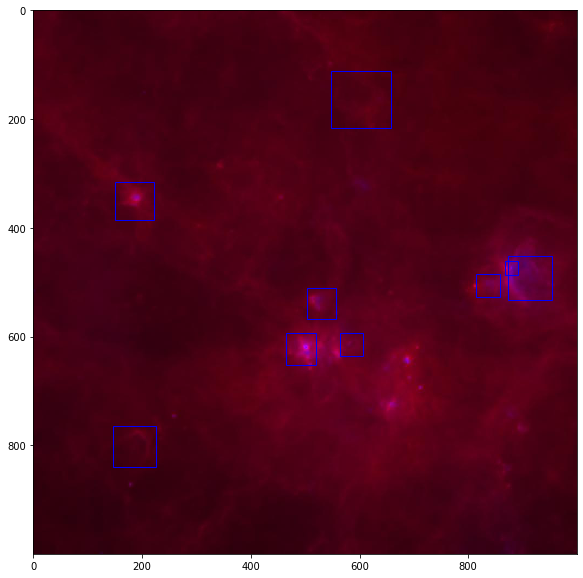

In [98]:
fig, ax = plt.subplots(figsize = (10,10))

plt.imshow(image)

for i in np.arange(np.shape(boxes)[0]):
    [miny,minx,maxy,maxx] = boxes[i]*1000 #1000x1000 images
    wid = maxx - minx
    hei = maxy - miny
    rect = plt.Rectangle((minx, miny), wid, hei, color='blue', fill=False) #width & height are mixed up! 
    ax.add_artist(rect)